### Analyze_rotated_stable_points - evaluate bias in rotated DEMs using selected unchanged points

These points were picked on hopefully stable points in mostly flat places: docks, lawns, bare spots in middens. Also, the yurt roofs. Typically, 3 to 5 points were picked on most features. 

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

from CoreBx_funcs import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define some functions
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az=np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))

    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [16]:
# coordinates for the whole-island box.

r={'name': 'ncorebx_refac', 'e0': 378490., 'n0': 3855740., 'xlen': 36500.0, 'ylen': 1500.0, 'dxdy': 1.0, 'theta': 42.0}

# Convert origin to UTM
xu,yu = box2UTMh(0.,0.,r['e0'],r['n0'],r['theta'])
print(xu,yu)

# reverse the calc to find the origin (UTM =0,0) in box coordinates.
# First, just do the rotation to see where Box = 0,0 falls
xb0,yb0 = box2UTMh(xu,yu,0.,0.,-r['theta'])
print(xb0,yb0)
# Then put in negative values for the offset
xb,yb = box2UTMh(xu,yu,-xb0,-yb0,-r['theta'])
print(xb,yb)

[378489.457] [3855740.501]
[2861266.46086384] [2612114.72183892]
[array([0.])] [array([0.])]


In [17]:
# Read in the list of stable points. Elevations were picked from the DEMs with Global Mapper. Elevations for Sep are from
# the old _crop version of the DEM.... .nc version read in below is from the newer _v3 version.
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\Santa_Cruz_Products\\stable_points\\All_points.csv",header = 0)

# convert UTM X, Y to rotated coords xrl, yrl
X = df["X"].values
Y = df["Y"].values
#TODO: why does this return a list of arrays?
xrl,yrl = box2UTMh(X,Y,-xb0,-yb0,-r['theta'])
# this fixes it...probably should fix box2UTMh
xrot = np.concatenate(xrl).ravel()
yrot = np.concatenate(yrl).ravel()

df["xr"] = xrot
df["yr"] = yrot

In [18]:
# read in the multi-map .nc file

# Dates for DEMs
dates = ([\
         "2018-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26",\
         "2020-02-09",\
         "2020-04-09",\
         "2020-08-05",\
         "2020-08-09",\
         "2020-09-28",\
         "2021-05-30"])
titles = ([\
#         "Oct 6 2018 post-Florence"\
         "Aug 30 2019 pre-Dorian",\
         "Sep 12-13 2019 post-Dorian",\
         "Oct 11 2019 lidar merge",\
         "Nov 26 2019 post-Nor'easter",\
         "Feb 8-9 2020",\
         "May 8-9 2020",\
         "Aug 2 2020 pre-Isaias",\
         "Aug 5-9 2020 post-Isaias",\
         "Sep 28 2020 post-Teddy",\
         "May 30 2021"])



# ALERT - change this line to offset final results or not
#offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317])
offset = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0])

fn = r['name']+'.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] + offset[i]    

nmaps, ncross, nalong:  9 1500 36650


In [25]:
# Use rotated coordinates as indices into the maps to get elevations.
ix = df["xr"].values.astype(np.int64)
iy = df["yr"].values.astype(np.int64)
nx = len(ix)
zr = np.ones((nx,nmaps))
for j in range(0, nmaps):
    for i in range(0, nx):
        zr[i,j] = dsaa[j,iy[i],ix[i]].values


In [46]:
zr[np.abs(zr)>10]=np.nan

In [47]:
anom = np.nan*np.ones_like(zr)
for i in range(0,nx):
    anom[i,:]=zr[i,:]-np.mean(zr[i,:])

In [71]:
anom = anom[np.where(~np.isnan(anom))].reshape((nx-9,9))
print(np.shape(anom))

(44, 9)


In [72]:
mean_anom = np.mean(anom,0)
std_anom = np.std(anom,0)
mean_anom

array([ 0.11614345,  0.09069495,  0.06901188,  0.07387553, -0.12387822,
       -0.11202377, -0.00808444, -0.07805204, -0.02768733])

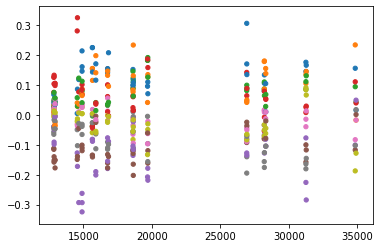

In [59]:
ixa = np.tile(ix,(nmaps,1)).T
for i in range(0,nx):
    plt.scatter(ixa[i,:],anom[i,:],s=18,c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])


In [66]:
sum(np.isnan(anom))

array([9, 9, 9, 9, 9, 9, 9, 9, 9])

In [67]:
anom

array([[ 2.61139599e-02,  2.50149418e-02,  3.14014228e-02,
         7.47233007e-02, -3.99061544e-02, -1.12279782e-01,
         4.54215581e-02, -5.76024315e-02,  7.11318447e-03],
       [ 6.73258115e-02,  1.02211405e-02,  2.26573661e-02,
         1.24664849e-01, -4.03304236e-02, -1.15419005e-01,
         2.30199273e-03, -6.53209285e-02, -6.10080221e-03],
       [ 3.92350855e-02,  2.19343296e-02,  4.58599082e-02,
         1.26931582e-01, -9.11582218e-02, -1.40083094e-01,
         1.87073780e-02, -4.02008281e-02,  1.87738604e-02],
       [ 2.90285366e-02,  3.21590273e-02,  7.43730949e-02,
         1.03259130e-01, -4.83854418e-02, -1.58018774e-01,
         1.24455688e-02, -4.50036455e-02,  1.42503541e-04],
       [ 4.07426942e-02,  9.46448104e-03,  5.12034981e-02,
         1.31985676e-01, -9.84958577e-02, -1.52224724e-01,
         2.15606877e-02, -1.70491646e-02,  1.28127094e-02],
       [ 3.50413317e-02, -3.60299166e-02,  5.54777244e-02,
         1.04688029e-01, -4.67771957e-03, -1.513505

In [9]:
# looks like three points are outside the domain. Drop them from the dataframe
dfc = df[df['zr Sep']>-10.].reset_index(drop=True)

# Calculate the average for each row for the four maps (don't average in the lidar)
col = dfc.loc[: , "zr Aug":"zr Nov"]
dfc['mean']=col.mean(axis=1)

# Calculate the anomoly for each point
dfc['gnd50 anom']=dfc['lidar_gnd50']-dfc['mean']
dfc['all90 anom']=dfc['lidar all90']-dfc['mean']
dfc['first50 anom']=dfc['lidar_first50']-dfc['mean']
dfc['Aug anom']=dfc['zr Aug']-dfc['mean']
dfc['Sep anom']=dfc['zr Sep']-dfc['mean']
dfc['Oct anom']=dfc['zr Oct']-dfc['mean']
dfc['Nov anom']=dfc['zr Nov']-dfc['mean']

In [11]:
df_anom = dfc.loc[:,"gnd50 anom":"Nov anom"].copy()

In [12]:
%run -i CoreBx_funcs
print(df_anom.mean())
print(df_anom.median())
print(df_anom.std())

stat_summary(df_anom['Aug anom'].values,iprint=True)
stat_summary(df_anom['Sep anom'].values,iprint=True)
stat_summary(df_anom['Oct anom'].values,iprint=True)
stat_summary(df_anom['Nov anom'].values,iprint=True)

gnd50 anom     -1.279436e-01
all90 anom     -4.996364e-02
first50 anom    1.387476e+00
Aug anom        1.636533e-07
Sep anom        4.703386e-08
Oct anom        2.423299e-07
Nov anom       -4.530171e-07
dtype: float64
gnd50 anom     -0.118025
all90 anom     -0.064360
first50 anom    1.371008
Aug anom       -0.011187
Sep anom       -0.009510
Oct anom       -0.006209
Nov anom       -0.005499
dtype: float64
gnd50 anom      0.066254
all90 anom      0.140018
first50 anom    0.662200
Aug anom        0.052332
Sep anom        0.059450
Oct anom        0.050611
Nov anom        0.069708
dtype: float64
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.052
min    = -0.109
max    = 0.123
d5     = -0.068
d25    = -0.035
d50    = -0.011
d75    = 0.029
d95    = 0.103
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.059
min    = -0.111
max    = 0.166
d5     = -0.074
d25    = -0.042
d50    = -0.010
d75    = 0.045
d95    = 0.093
n      = 50.000
nnan   = 0.000
mean   = 0.000
std    = 0.050
m

{'n': 50,
 'nnan': 0,
 'mean': -4.5301705128508727e-07,
 'std': 0.06900702379004166,
 'min': -0.1173504128314653,
 'max': 0.2164959765147385,
 'd5': -0.0983888535995352,
 'd25': -0.05121664919455793,
 'd50': -0.005499113679110046,
 'd75': 0.03224896785031678,
 'd95': 0.08559765719414776}

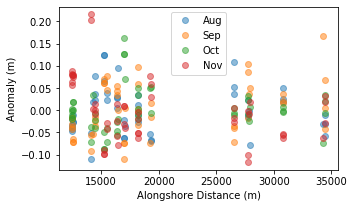

In [13]:
plt.figure(figsize=(5,3))
plt.plot(dfc['xr'],dfc['Aug anom'],'o',alpha=.5,label='Aug')
plt.plot(dfc['xr'],dfc['Sep anom'],'o',alpha=.5,label='Sep')
plt.plot(dfc['xr'],dfc['Oct anom'],'o',alpha=.5,label='Oct')
plt.plot(dfc['xr'],dfc['Nov anom'],'o',alpha=.5,label='Nov')
plt.legend()
plt.ylabel('Anomaly (m)')
plt.xlabel('Alongshore Distance (m)')
plt.savefig('unchanged_pts_along_anom_adjusted_dems.png',dpi=200,bbox_inches = 'tight')

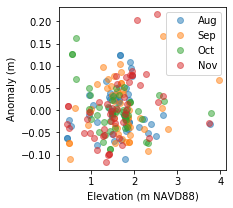

In [14]:
plt.figure(figsize=(3,3))
plt.plot(dfc['Aug'],dfc['Aug anom'],'o',alpha=.5,label='Aug')
plt.plot(dfc['Sep'],dfc['Sep anom'],'o',alpha=.5,label='Sep')
plt.plot(dfc['Oct'],dfc['Oct anom'],'o',alpha=.5,label='Oct')
plt.plot(dfc['Nov'],dfc['Nov anom'],'o',alpha=.5,label='Nov')
plt.legend()
plt.ylabel('Anomaly (m)')
plt.xlabel('Elevation (m NAVD88)')
plt.savefig('unchanged_pts_elev_anom_adjusted_dems.png',bbox_inches = 'tight',dpi=200)

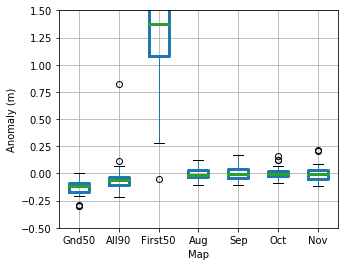

In [16]:
# boxplot of anomolies
fig, ax =plt.subplots(figsize=(5,4))
boxprops = dict(linestyle='-', linewidth=3, color='k')
medianprops = dict(linestyle='-', linewidth=3, color='k')
bp=df_anom.boxplot(figsize=(6,5),grid=True,boxprops=boxprops, medianprops=medianprops)
plt.ylabel('Difference from Four-Map Mean (m)')
plt.ylim((-0.5,1.5))
plt.ylabel('Anomaly (m)')
ax.set_xticklabels(["Gnd50","All90","First50","Aug","Sep","Oct","Nov"])
plt.xlabel('Map')
plt.savefig('unchanged_pts_boxplot_adjusted_dems.png',dpi=200,bbox_inches = 'tight')
#plt.savefig('offset_corrected_pts_boxplot_adjusted_dems.png',dpi=200,bbox_inches = 'tight')